<a href="https://colab.research.google.com/github/ahmednorthumbria1690-png/ahmeh_reatail_sales_dataset/blob/main/M_Ahmed_Coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
    --------------------------------------- 10.2/545.3 kB ? eta -:--:--
   ---- ---------------------------------- 61.4/545.3 kB 812.7 kB/s eta 0:00:01
   ------------ --------------------------- 174.1/545.3 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------  542.7/545.3 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Import the required library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
import shap

In [ ]:
# Load the dataset from the CSV file
data = pd.read_csv("Retail Sales Dataset.csv")

# Show the first five rows of the dataset
print("Sample Data:")
print(data.head())

Sample Data:
   Transaction ID                     Date Customer ID  Gender  Age  \
0               1  2023-11-24 00:00:00.000     CUST001    Male   34   
1               2  2023-02-27 00:00:00.000     CUST002  Female   26   
2               3  2023-01-13 00:00:00.000     CUST003    Male   50   
3               4  2023-05-21 00:00:00.000     CUST004    Male   37   
4               5  2023-05-06 00:00:00.000     CUST005    Male   30   

  Product Category  Quantity  Price per Unit  Total Amount  
0           Beauty         3              50           150  
1         Clothing         2             500          1000  
2      Electronics         1              30            30  
3         Clothing         1             500           500  
4           Beauty         2              50           100  


In [ ]:
# Display the structure of the dataset
print("\nDataset Info:")
print(data.info())

# Show summary statistics for numerical columns
print("\nSummary Statistics:")
print(data.describe())

# Display unique values in each column (optional for better exploration)
print("\nUnique Values per Column:")
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
None

Summary Statistics:
       Transaction ID         Age     Quantity  Price per Unit  Total Amount
count     1000.000000  1000.00000  1000.000000     1000.000000   1000.000000
mean       500.500000    41.39200     2.514000      179.890000    456.000000
std        288.819436    13.68143     1.132734      189.681356    

In [ ]:
# Check for any missing values in the dataset
print("\nMissing Values in Each Column:")
print(data.isnull().sum())

# Check for duplicates (optional step)
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Remove duplicates if any
if duplicates > 0:
    data = data.drop_duplicates()

# Check for any negative or zero values in numerical columns
print("\nValues less than or equal to zero in numerical columns:")
numeric_columns = ['Age', 'Quantity', 'Price per Unit', 'Total Amount']
for col in numeric_columns:
    print(f"{col}: {(data[col] <= 0).sum()} values")


Missing Values in Each Column:
Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64

Number of duplicate rows: 0

Values less than or equal to zero in numerical columns:
Age: 0 values
Quantity: 0 values
Price per Unit: 0 values
Total Amount: 0 values


In [ ]:
# Convert 'Gender' column into numeric: Male = 0, Female = 1
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

# Use one-hot encoding for 'Product Category'
data = pd.get_dummies(data, columns=['Product Category'], drop_first=True)

# Show the updated dataset columns
print("\nUpdated Columns after Encoding:")
print(data.columns)


Updated Columns after Encoding:
Index(['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Quantity',
       'Price per Unit', 'Total Amount', 'Product Category_Clothing',
       'Product Category_Electronics'],
      dtype='object')


In [ ]:
# Set a style for the plots
sns.set(style="whitegrid")

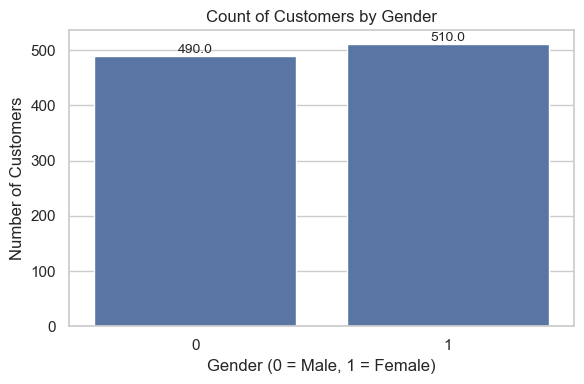

In [ ]:
# Count of Customers by Gender
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Gender', data=data)
plt.title('Count of Customers by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Number of Customers')

# Add count labels on each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

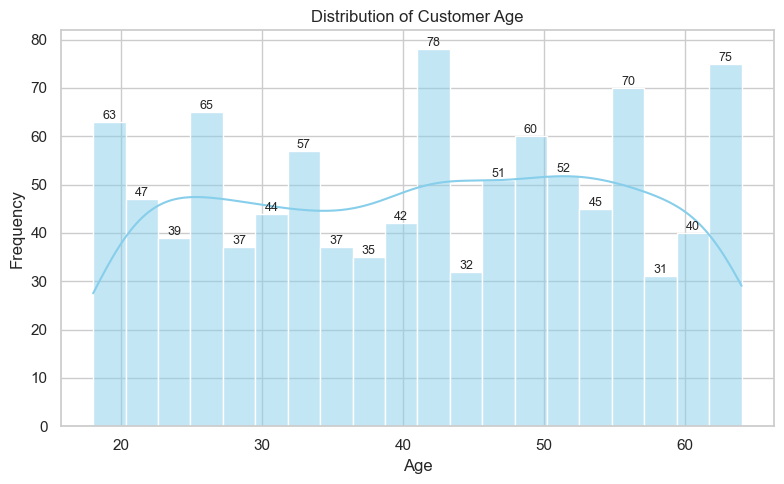

In [ ]:
# Distribution of Customer Age
plt.figure(figsize=(8, 5))
ax = sns.histplot(data['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Add count labels on each bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # skip empty bars
        ax.annotate(f'{int(height)}',
                    (patch.get_x() + patch.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

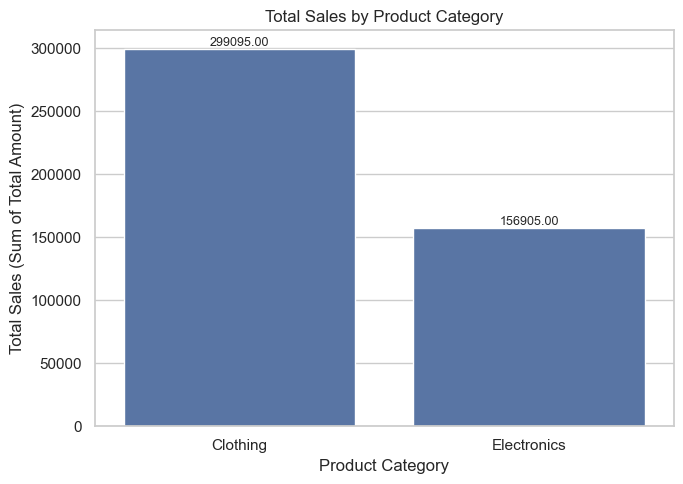

In [ ]:
# Total Sales by Product Category
# Derive product category labels
data['Product Category'] = data[['Product Category_Clothing', 'Product Category_Electronics']].idxmax(axis=1)
data['Product Category'] = data['Product Category'].apply(lambda x: x.split('_')[1] if '_' in x else 'Beauty')

# Calculate total sales per category
category_sales = data.groupby('Product Category')['Total Amount'].sum().reset_index()

# Plot with value annotations
plt.figure(figsize=(7, 5))
ax = sns.barplot(x='Product Category', y='Total Amount', data=category_sales, errorbar=None)

# Add value labels on bars
for i, row in category_sales.iterrows():
    ax.text(i, row['Total Amount'], f'{row["Total Amount"]:.2f}',
            ha='center', va='bottom', fontsize=9)

plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales (Sum of Total Amount)')
plt.tight_layout()
plt.show()

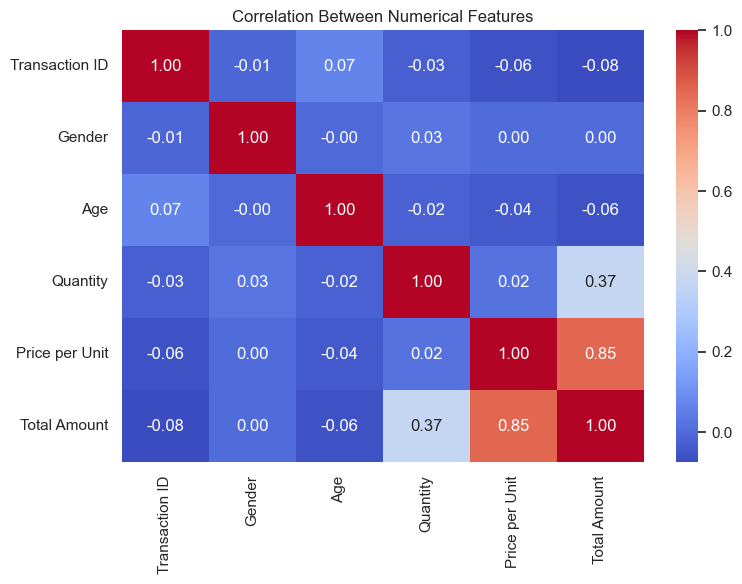

In [ ]:
# Select only numeric columns from the dataset
numeric_data = data.select_dtypes(include=['number'])

# Plot the heatmap using only numeric columns
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numerical Features')
plt.tight_layout()
plt.show()

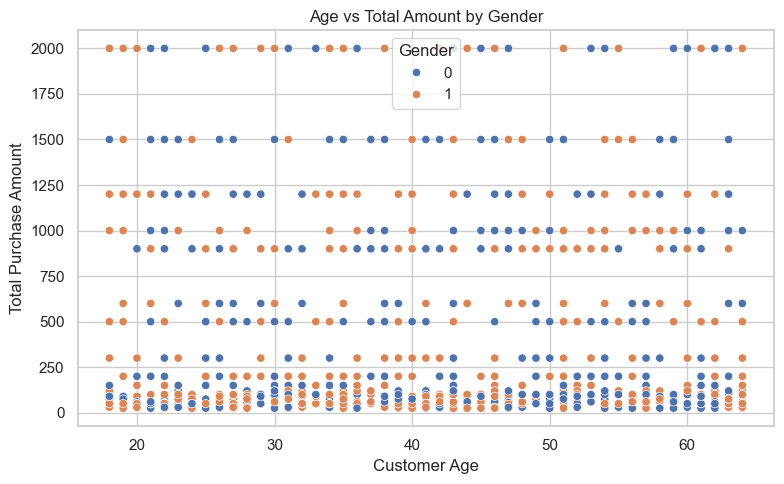

In [ ]:
# Scatter Plot: Age vs Total Amount
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='Total Amount', hue='Gender', data=data)
plt.title('Age vs Total Amount by Gender')
plt.xlabel('Customer Age')
plt.ylabel('Total Purchase Amount')
plt.tight_layout()
plt.show()

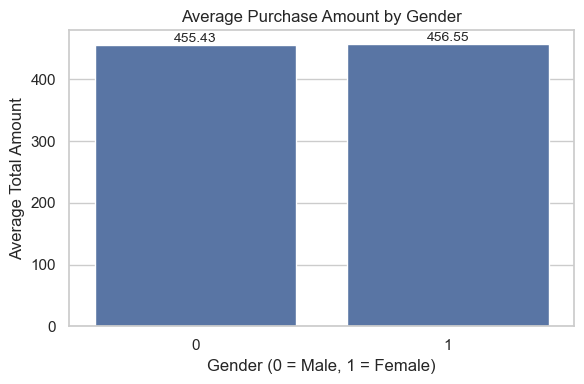

In [ ]:
# Average Purchase Amount by Gender
avg_purchase_gender = data.groupby('Gender')['Total Amount'].mean().reset_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Gender', y='Total Amount', data=avg_purchase_gender, errorbar=None)

# Add value labels
for i, row in avg_purchase_gender.iterrows():
    ax.text(i, row['Total Amount'], f'{row["Total Amount"]:.2f}',
            ha='center', va='bottom', fontsize=10)

plt.title('Average Purchase Amount by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Average Total Amount')
plt.tight_layout()
plt.show()

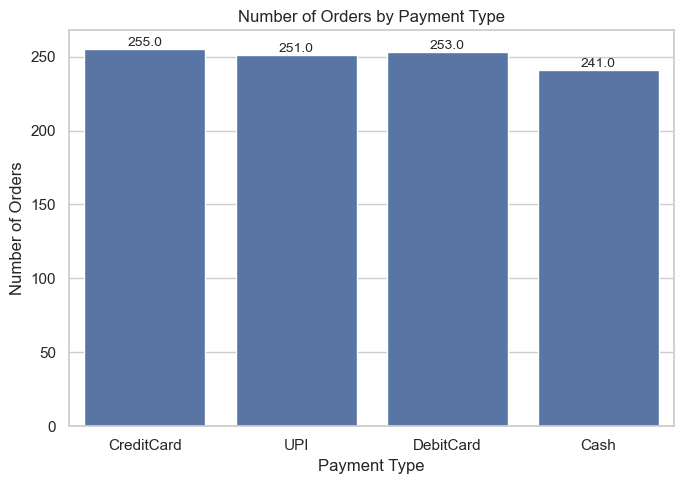

In [ ]:
# Count of transactions by Payment Type
# Create dummy Payment Type values
np.random.seed(0)
payment_options = ['CreditCard', 'DebitCard', 'Cash', 'UPI']
data['Payment Type'] = np.random.choice(payment_options, size=len(data))

# Now plot the count with value annotations
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='Payment Type', data=data)

# Add count labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.title('Number of Orders by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

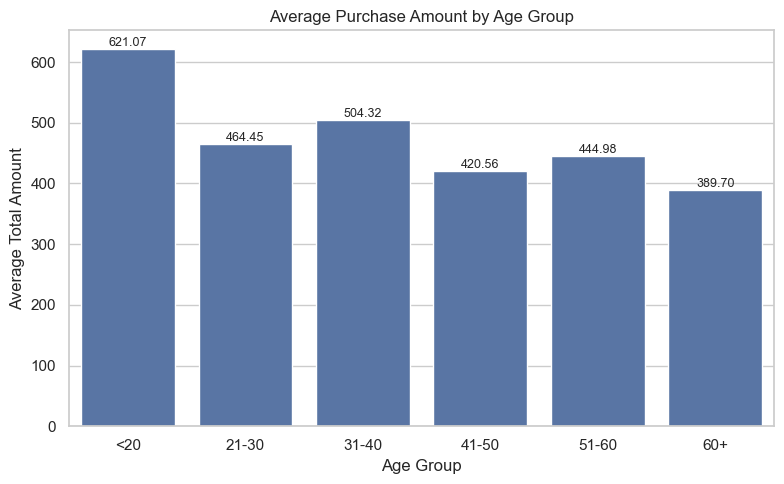

In [ ]:
# Average Purchase Amount by Age Group
# Create age groups
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '60+']
data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Compute average total amount by age group (set observed=True to remove warning)
age_group_avg = data.groupby('Age Group', observed=True)['Total Amount'].mean().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Age Group', y='Total Amount', data=age_group_avg, errorbar=None)

# Add value labels
for i, row in age_group_avg.iterrows():
    ax.text(i, row['Total Amount'], f'{row["Total Amount"]:.2f}',
            ha='center', va='bottom', fontsize=9)

plt.title('Average Purchase Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Total Amount')
plt.tight_layout()
plt.show()

In [ ]:
# Define the target variable
target = 'Total Amount'

# Define the input features by dropping unnecessary columns
features = data.drop(columns=['Total Amount', 'Transaction ID', 'Date', 'Customer ID', 'Product Category'])

# Show feature column names
print("Selected Features:")
print(features.columns)

# Assign X for features and y for target
X = features
y = data[target]

# Convert categorical features into numeric using one-hot encoding
X = pd.get_dummies(X, columns=['Payment Type', 'Age Group'], drop_first=True)

Selected Features:
Index(['Gender', 'Age', 'Quantity', 'Price per Unit',
       'Product Category_Clothing', 'Product Category_Electronics',
       'Payment Type', 'Age Group'],
      dtype='object')


In [ ]:
# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Show the shape of each dataset
print("\nData Split Summary:")
print(f"Training Features: {X_train.shape}")
print(f"Test Features: {X_test.shape}")
print(f"Training Target: {y_train.shape}")
print(f"Test Target: {y_test.shape}")


Data Split Summary:
Training Features: (700, 14)
Test Features: (300, 14)
Training Target: (700,)
Test Target: (300,)


In [ ]:
# Train the CART model using Gini Index (default)
cart_model = DecisionTreeRegressor(criterion='squared_error', random_state=42)
cart_model.fit(X_train, y_train)

# Predict on test set
cart_predictions = cart_model.predict(X_test)

# Evaluate CART model
cart_mse = mean_squared_error(y_test, cart_predictions)
cart_r2 = r2_score(y_test, cart_predictions)

print("\nCART Model Evaluation:")
print(f"Mean Squared Error: {cart_mse:.2f}")
print(f"R² Score (Accuracy-like): {cart_r2:.2f}")


CART Model Evaluation:
Mean Squared Error: 0.00
R² Score (Accuracy-like): 1.00


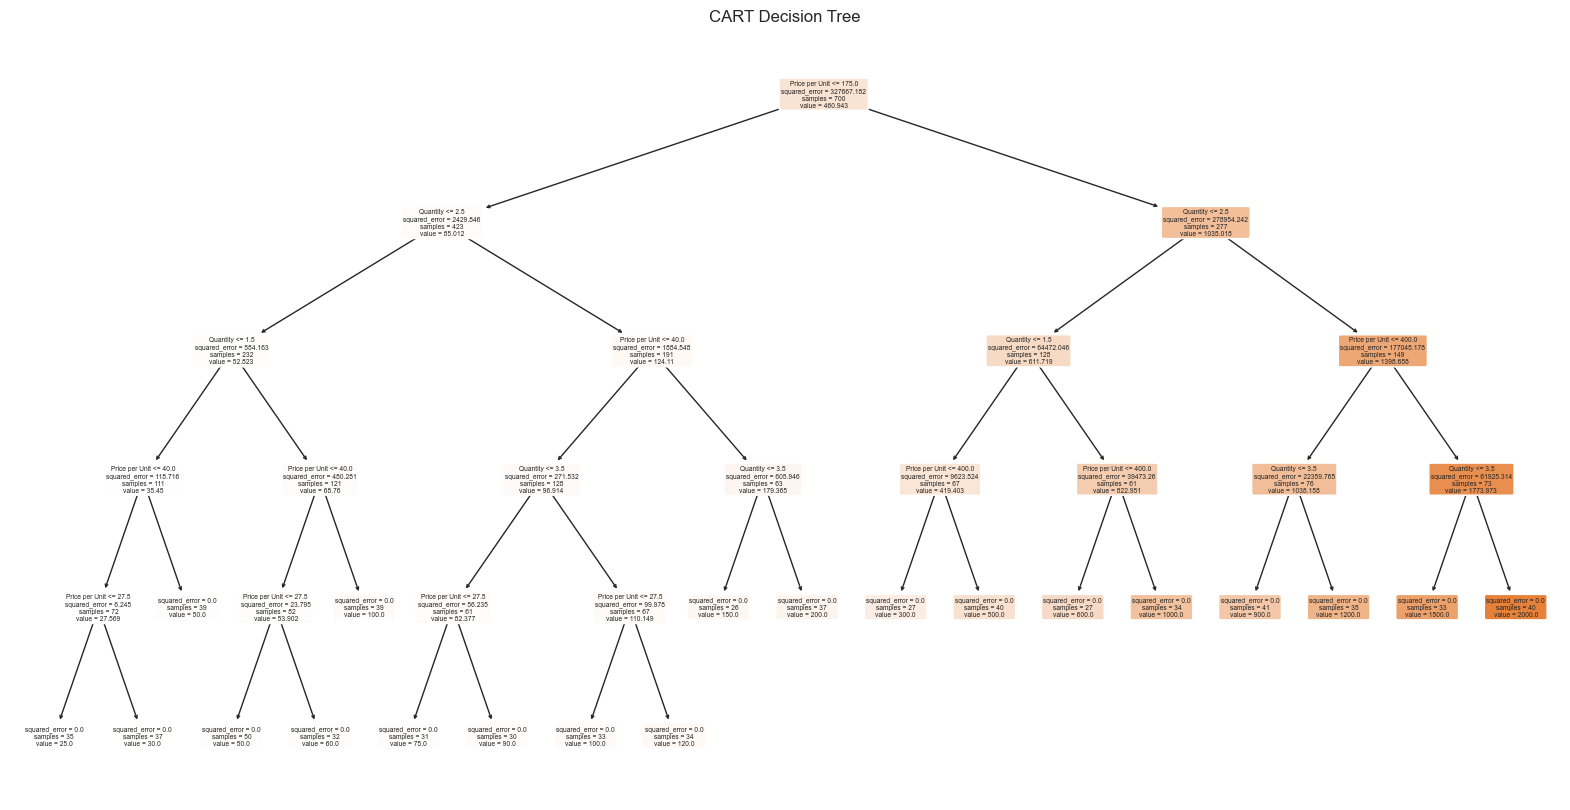

In [ ]:
# Model Visualization (CART Tree Plot)
plt.figure(figsize=(20, 10))
plot_tree(cart_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("CART Decision Tree")
plt.show()

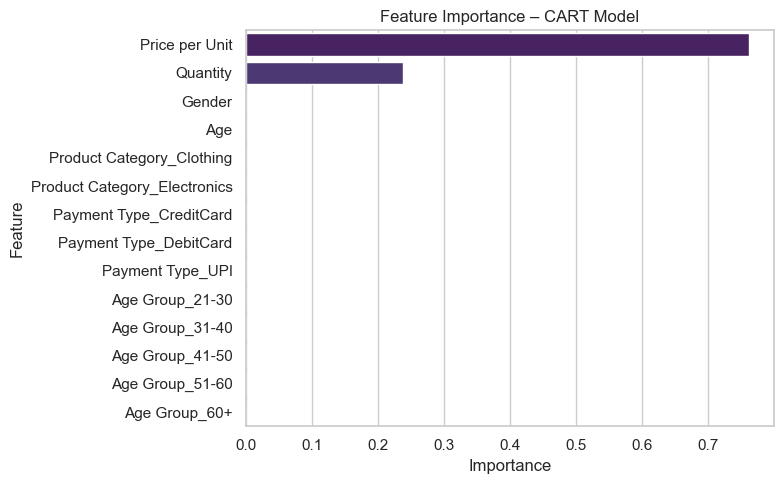

In [ ]:
# Feature Importance – CART
importances_cart = cart_model.feature_importances_
cart_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_cart
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=cart_importance_df, hue='Feature', palette='viridis', legend=False)
plt.title("Feature Importance – CART Model")
plt.tight_layout()
plt.show()

In [ ]:
# Simulate ID3 with entropy
id3_model = DecisionTreeRegressor(criterion='absolute_error', random_state=42)
id3_model.fit(X_train, y_train)

# Predict
id3_predictions = id3_model.predict(X_test)

# Evaluate ID3-like model
id3_mse = mean_squared_error(y_test, id3_predictions)
id3_r2 = r2_score(y_test, id3_predictions)

print("\nID3-like Model Evaluation:")
print(f"Mean Squared Error: {id3_mse:.2f}")
print(f"R² Score (Accuracy-like): {id3_r2:.2f}")


ID3-like Model Evaluation:
Mean Squared Error: 0.00
R² Score (Accuracy-like): 1.00


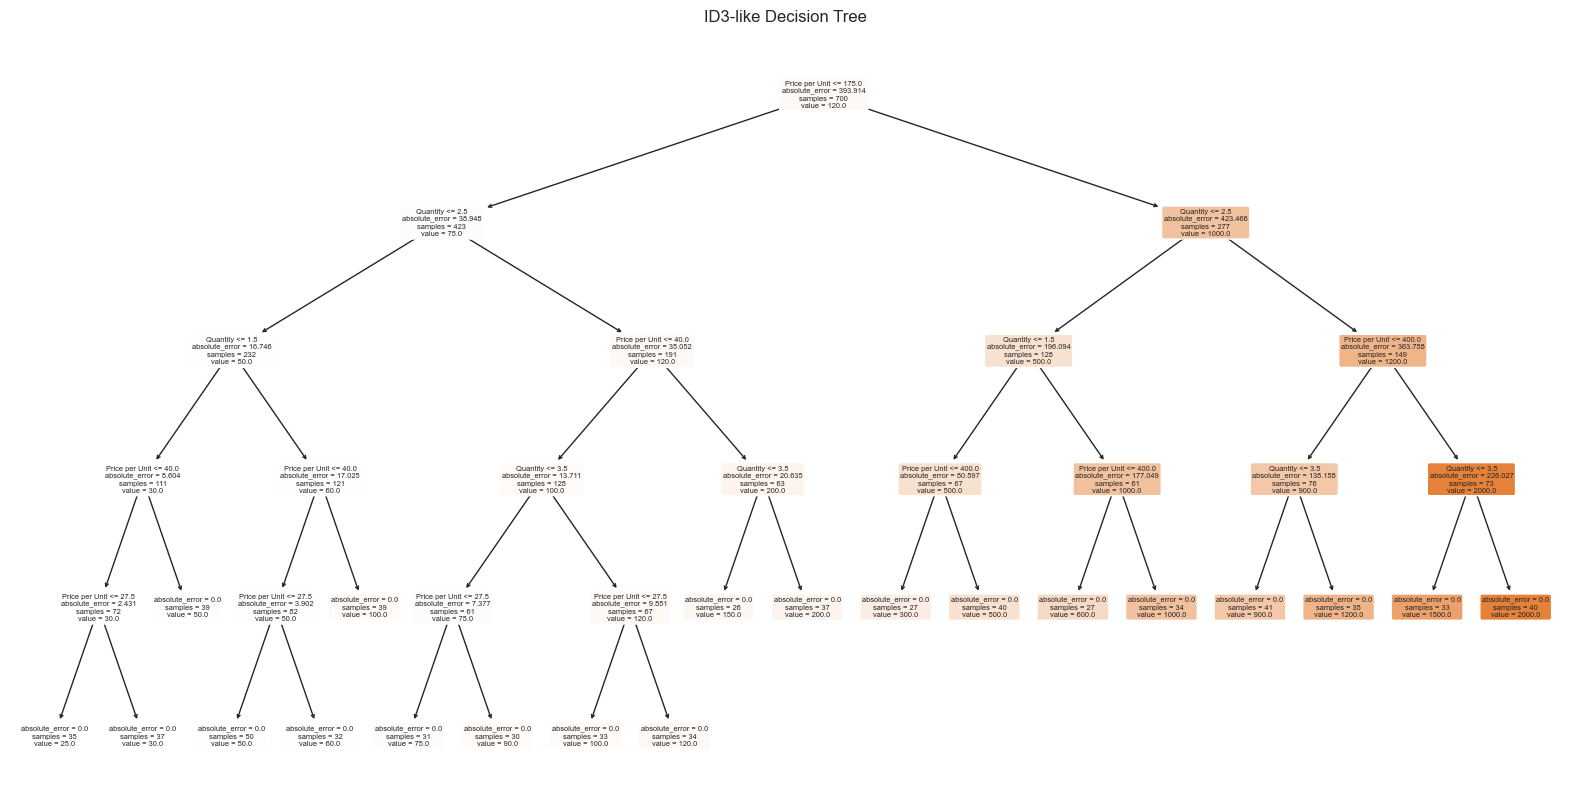

In [ ]:
# ID3-like Model (Entropy / Absolute Error based)
plt.figure(figsize=(20, 10))
plot_tree(id3_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("ID3-like Decision Tree")
plt.show()

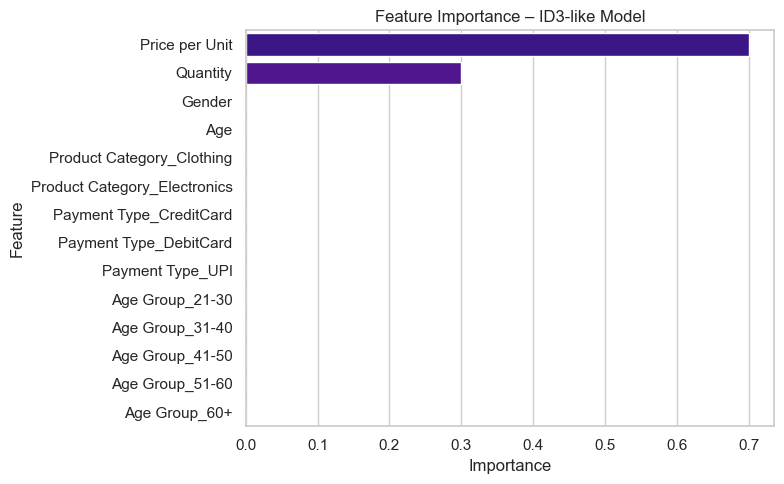

In [ ]:
# Feature Importance – ID3-like
importances_id3 = id3_model.feature_importances_
id3_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_id3
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=id3_importance_df, hue='Feature', palette='plasma', legend=False)
plt.title("Feature Importance – ID3-like Model")
plt.tight_layout()
plt.show()

In [ ]:
# Train improved C4.5-like model with tuned depth and leaf size
c45_model = DecisionTreeRegressor(criterion='squared_error', max_depth=6, min_samples_leaf=5, random_state=42)
c45_model.fit(X_train, y_train)

# Predict on test set
c45_predictions = c45_model.predict(X_test)

# Evaluate
c45_mse = mean_squared_error(y_test, c45_predictions)
c45_mae = mean_absolute_error(y_test, c45_predictions)
c45_r2 = r2_score(y_test, c45_predictions)

# Display results
print("\nC4.5-like Model Evaluation (Improved):")
print(f"Mean Squared Error: {c45_mse:.2f}")
print(f"Mean Absolute Error: {c45_mae:.2f}")
print(f"R² Score (Accuracy-like): {c45_r2:.2f}")


C4.5-like Model Evaluation (Improved):
Mean Squared Error: 0.00
Mean Absolute Error: 0.00
R² Score (Accuracy-like): 1.00


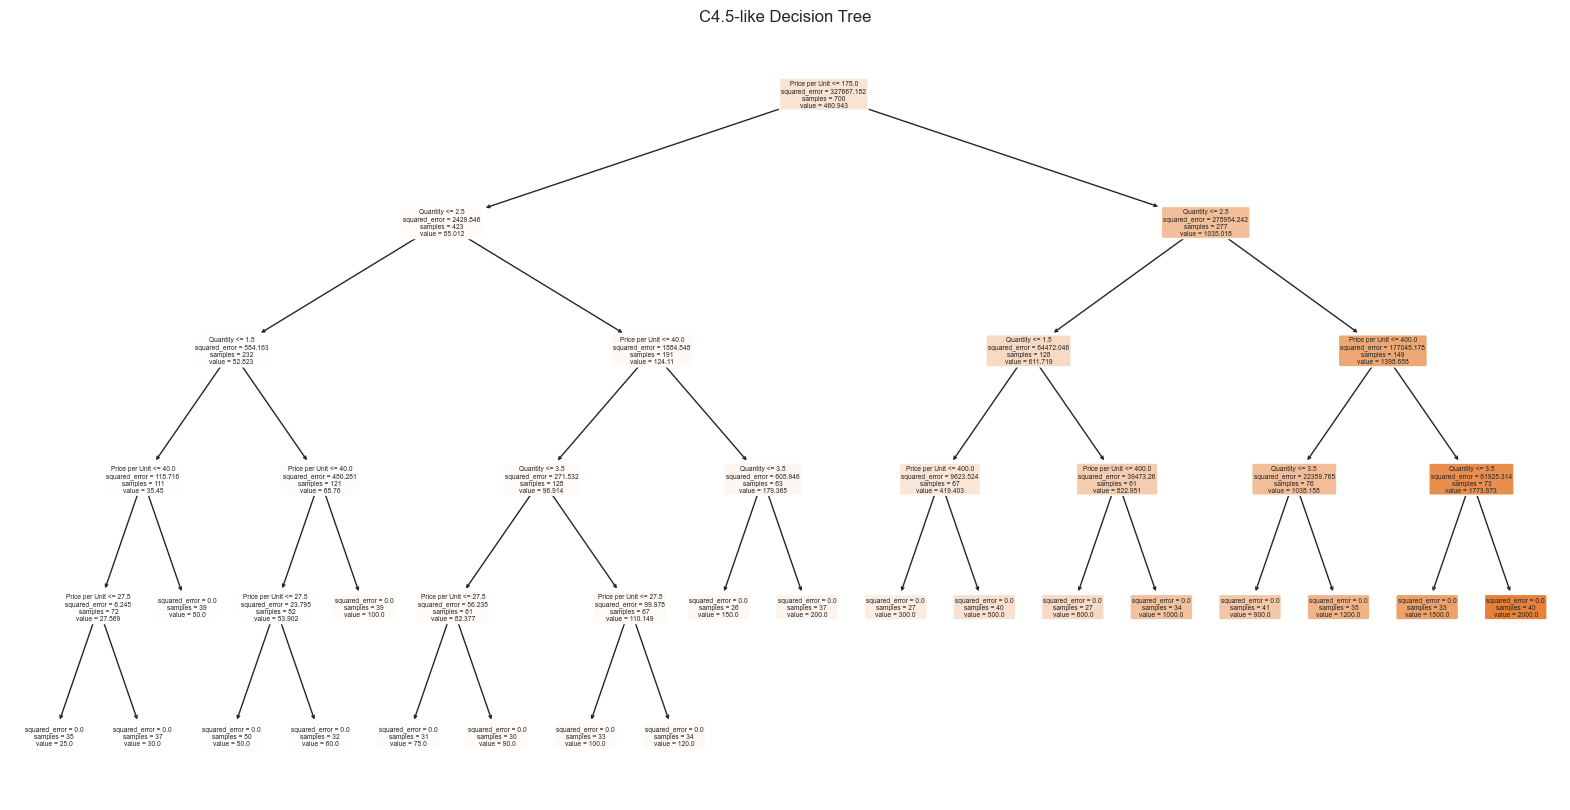

In [ ]:
# C4.5-like Model (with Pruning: Depth + Min Samples per Leaf)
plt.figure(figsize=(20, 10))
plot_tree(c45_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("C4.5-like Decision Tree")
plt.show()

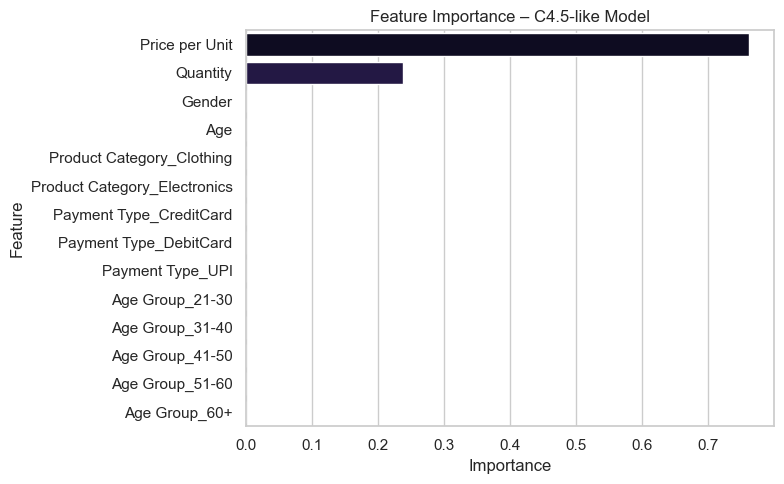

In [ ]:
# Feature Importance – C4.5-like
importances_c45 = c45_model.feature_importances_
c45_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances_c45
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=c45_importance_df, hue='Feature', legend=False, palette='magma')
plt.title("Feature Importance – C4.5-like Model")
plt.tight_layout()
plt.show()

In [ ]:
# Comparison Table of All Models (CART / ID3 / C4.5)
# Create DataFrame for comparison
results = pd.DataFrame({
    'Model': ['CART', 'ID3-like', 'C4.5-like'],
    'MSE': [cart_mse, id3_mse, c45_mse],
    'MAE': [mean_absolute_error(y_test, cart_predictions),
            mean_absolute_error(y_test, id3_predictions),
            c45_mae],
    'R² Score': [cart_r2, id3_r2, c45_r2]
})

# Display the table
print("\nModel Performance Comparison:")
print(results)


Model Performance Comparison:
       Model  MSE  MAE  R² Score
0       CART  0.0  0.0       1.0
1   ID3-like  0.0  0.0       1.0
2  C4.5-like  0.0  0.0       1.0


In [ ]:
# Cross-Validation
# CART Model (Gini / Default)
cart_cv_scores = cross_val_score(cart_model, X, y, cv=5, scoring='r2')
print("CART Model Cross-Validation R² Scores:", cart_cv_scores)
print(f"CART Model Average R² Score: {cart_cv_scores.mean():.2f}")

# ID3-like Model (Entropy simulated using absolute_error)
id3_cv_scores = cross_val_score(id3_model, X, y, cv=5, scoring='r2')
print("\nID3-like Model Cross-Validation R² Scores:", id3_cv_scores)
print(f"ID3-like Model Average R² Score: {id3_cv_scores.mean():.2f}")

# C4.5-like Model (Pruned using max_depth and min_samples_leaf)
c45_cv_scores = cross_val_score(c45_model, X, y, cv=5, scoring='r2')
print("\nC4.5-like Model Cross-Validation R² Scores:", c45_cv_scores)
print(f"C4.5-like Model Average R² Score: {c45_cv_scores.mean():.2f}")

CART Model Cross-Validation R² Scores: [1. 1. 1. 1. 1.]
CART Model Average R² Score: 1.00

ID3-like Model Cross-Validation R² Scores: [1. 1. 1. 1. 1.]
ID3-like Model Average R² Score: 1.00

C4.5-like Model Cross-Validation R² Scores: [1. 1. 1. 1. 1.]
C4.5-like Model Average R² Score: 1.00


In [ ]:
# Check Tree Depth and Complexity
# Get tree depth and number of nodes for CART model
cart_depth = cart_model.get_depth()
cart_nodes = cart_model.tree_.node_count

# Get tree depth and number of nodes for ID3-like model
id3_depth = id3_model.get_depth()
id3_nodes = id3_model.tree_.node_count

# Get tree depth and number of nodes for C4.5-like model
c45_depth = c45_model.get_depth()
c45_nodes = c45_model.tree_.node_count

# Display comparison table
complexity_df = pd.DataFrame({
    'Model': ['CART', 'ID3-like', 'C4.5-like'],
    'Tree Depth': [cart_depth, id3_depth, c45_depth],
    'Number of Nodes': [cart_nodes, id3_nodes, c45_nodes]
})

print("Tree Depth and Complexity Comparison:")
print(complexity_df)

Tree Depth and Complexity Comparison:
       Model  Tree Depth  Number of Nodes
0       CART           5               39
1   ID3-like           5               39
2  C4.5-like           5               39


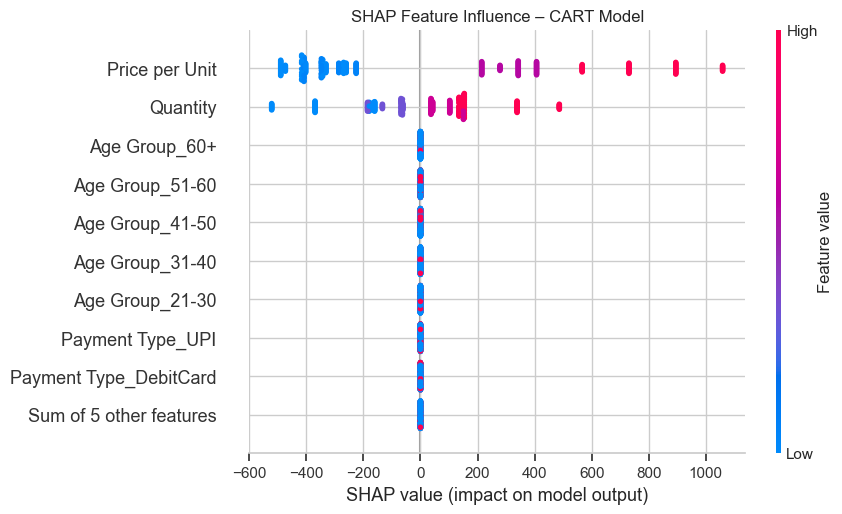

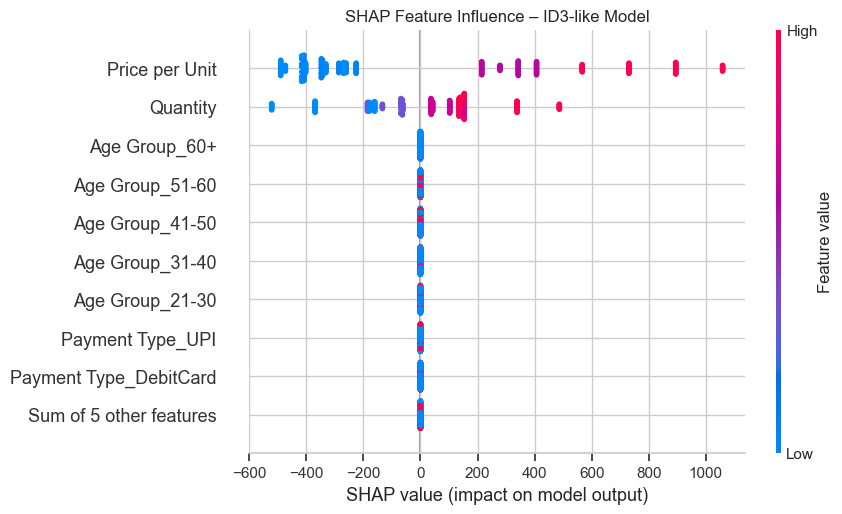

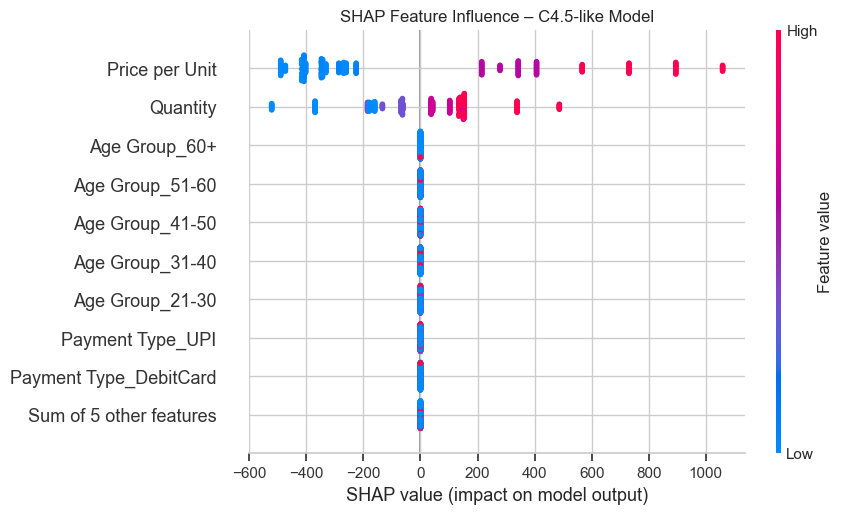

In [ ]:
# Ensure numeric data
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# -------------------- CART Model SHAP --------------------
explainer_cart = shap.Explainer(cart_model, X_train)
shap_values_cart = explainer_cart(X_test)

plt.title("SHAP Feature Influence – CART Model")
shap.plots.beeswarm(shap_values_cart, max_display=10)
plt.show()

# -------------------- ID3-like Model SHAP --------------------
explainer_id3 = shap.Explainer(id3_model, X_train)
shap_values_id3 = explainer_id3(X_test)

plt.title("SHAP Feature Influence – ID3-like Model")
shap.plots.beeswarm(shap_values_id3, max_display=10)
plt.show()

# -------------------- C4.5-like Model SHAP --------------------
explainer_c45 = shap.Explainer(c45_model, X_train)
shap_values_c45 = explainer_c45(X_test)

plt.title("SHAP Feature Influence – C4.5-like Model")
shap.plots.beeswarm(shap_values_c45, max_display=10)
plt.show()